# env setting

In [ ]:
#cannot use cs298 env (I don't know why) 
#install all dependencies 
!pip install tensorflow
!pip install pandas
!pip install seaborn

In [414]:
import os
import tensorflow as tf
import glob
import pandas as pd

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# helper functions
## read file 

In [415]:
#helper function from read_result.py
#get Train_EnvstepsSoFar and Eval_AverageReturn

def get_section_results(file):
    """
        requires tensorflow==1.12.0
    """
    X = []
    Y = []
    for e in tf.compat.v1.train.summary_iterator(file):
        for v in e.summary.value:
            if v.tag == 'Train_EnvstepsSoFar':#train steps
                X.append(v.simple_value)
            elif v.tag == 'Eval_AverageReturn':
                Y.append(v.simple_value)
    return X, Y

## Collect outcomes of multiple different random seeds


(no need to use because sns can plot derectly )

In [ ]:
'''

import os
from collections import defaultdict
import shutil 

#Collect return of multiple different random seeds by experiments name(prefix)

def average_results_of_seeds(prefix):
    
    data = defaultdict(dict) 
    data_diff_seeds = []
    
    
    for filename in os.listdir('data'): # list all files + directories in current folder
        if filename.startswith(prefix): # filter out files that start with specified prefix only
            print(filename) # found matched files

            # read each file 
            logdir = os.path.join('data', filename, 'events*')
            eventfile = glob.glob(logdir)[0] #retrieve files/pathnames matching a specified pattern
            X, data_this_seed  = get_section_results(eventfile)
   
            data_diff_seeds.append(data_this_seed)#append all the data
            
            # if the Experiment failed or interrupt, delete it
            if len(data_this_seed) < 10:
                print('remove this file',os.path.join('data', filename))
                shutil.rmtree(os.path.join('data', filename))

                
    #calculate mean and std over seeds
    data['return_mean'] = np.mean(data_diff_seeds, axis=0)
    data['return_std'] = np.std(data_diff_seeds, axis=0)
    #print('data',data)
    data = pd.DataFrame.from_dict(data)#transfrom to pd.DataFrame
    return data
'''

In [417]:
'''
#test example
data=average_results_of_seeds(prefix='q1_lb_no_rtg')
data
'''

q1_lb_no_rtg_dsa_seed_0_CartPole-v0_04-03-2021_10-28-41
q1_lb_no_rtg_dsa_seed_0_CartPole-v0_02-03-2021_12-11-23
q1_lb_no_rtg_dsa_seed_3_CartPole-v0_04-03-2021_10-28-41
q1_lb_no_rtg_dsa_seed_2_CartPole-v0_04-03-2021_10-28-41
q1_lb_no_rtg_dsa_seed_4_CartPole-v0_04-03-2021_10-28-41
q1_lb_no_rtg_dsa_seed_1_CartPole-v0_02-03-2021_12-11-23
q1_lb_no_rtg_dsa_seed_1_CartPole-v0_04-03-2021_10-28-41


,return_mean,return_std
0,36.991148,7.568155
1,36.794988,10.682175
2,41.696024,8.076750
3,55.996032,7.632867
4,56.085499,13.549256
...,...,...
95,192.714286,16.653736
96,192.809525,17.612996
97,188.809525,20.357017
98,193.809525,15.163506


## read data for plot

In [498]:
#read data from multiple files by name with same prefix
def read_data(prefix, env_name):
    full_data = pd.DataFrame()

    for filename in os.listdir('data'): # list all files + directories in current folder
        if filename.startswith(prefix): # filter out files that start with specified prefix(exp_name) only
            print(filename) # found matched files
            
            #____read file____
            logdir = os.path.join('data', filename, 'events*')#get the whole path of a specific file
            eventfile = glob.glob(logdir)[0] #retrieve files/pathnames matching a specified pattern
            X,Y = get_section_results(eventfile)#read data 
            
            # if the Experiment failed or interrupt, delete it
            if len(data_this_seed) < 10:
                print('remove this file',os.path.join('data', filename))
                shutil.rmtree(os.path.join('data', filename))
            
            #____get experiment and seed name____ from filename. To automaticly generate plot legend 
            split = filename.split('_')#split folder name of experement data  
            
            if 'seed' in split:
                Exp_list = split[1:split.index('seed')]
                Exp = '_'.join(Exp_list) 
                #print('split',split)
                #print(Exp_list)
                #print('Exp',Exp)
                seed_list= split[split.index('seed'):split.index(env_name)]
                seed = '_'.join(seed_list) 
            else:
                Exp_list = split[1:split.index(env_name)]
                Exp = '_'.join(Exp_list) 
            
            
                
                
            
            
            #____create dataset____
            data = pd.DataFrame({'Iteration': range(len(X)), 
                                 'Experiment': np.repeat(Exp, len(X)),
                                 #'seed':np.repeat(seed,len(X)),
                                 'Train_EnvstepsSoFar': X, 
                                 'Eval_AverageReturn': Y})
            #data['Eval_AverageReturn_Smooth'] = data['Eval_AverageReturn'].ewm(alpha=0.6).mean()
            if 'seed' in split:
                data['seed']=np.repeat(seed,len(X))
            
        
            full_data = pd.concat([full_data, data], axis=0, ignore_index=True)
            full_data.head()
            
            
    return full_data


#test example
data_q1_lb= read_data(exp_name='q1_lb',env_name= 'CartPole-v0')

q1_lb_no_rtg_dsa_seed_3_CartPole-v0_04-03-2021_16-50-58
q1_lb_rtg_na_seed_3_CartPole-v0_04-03-2021_16-50-59
q1_lb_rtg_dsa_seed_4_CartPole-v0_04-03-2021_16-50-59
q1_lb_rtg_dsa_seed_1_CartPole-v0_04-03-2021_16-50-58
q1_lb_rtg_dsa_seed_2_CartPole-v0_04-03-2021_16-50-58
q1_lb_no_rtg_dsa_seed_0_CartPole-v0_04-03-2021_16-50-58
q1_lb_rtg_na_seed_0_CartPole-v0_04-03-2021_16-50-59
q1_lb_rtg_dsa_seed_3_CartPole-v0_04-03-2021_16-50-58
q1_lb_rtg_na_seed_1_CartPole-v0_04-03-2021_16-50-59
q1_lb_no_rtg_dsa_seed_1_CartPole-v0_04-03-2021_16-50-59
q1_lb_no_rtg_dsa_seed_4_CartPole-v0_04-03-2021_16-50-58
q1_lb_rtg_na_seed_4_CartPole-v0_04-03-2021_16-50-59
q1_lb_rtg_na_seed_2_CartPole-v0_04-03-2021_16-50-58
q1_lb_no_rtg_dsa_seed_2_CartPole-v0_04-03-2021_16-50-58
q1_lb_rtg_dsa_seed_0_CartPole-v0_04-03-2021_16-50-58


## Plot 

In [420]:
#set plot
figsize=(5.7, 3)
export_dir = os.path.join('solution', 'figures')

sns.set_theme()#seaborn  On later versions, it must be explicitly invoked.
sns.set_context("paper")
sns.set_style("whitegrid")

### Plot functions

In [456]:
#plot mean over different seeds 
'''
plot_std : flag plot std or not
'''

def plot_return(data_to_plot,fig_name, plot_std=False):
    plt.figure(figsize=figsize)
    if plot_std == True :
        sns.lineplot(data=data_to_plot, x='Iteration', y='Eval_AverageReturn', hue='Experiment',ci="sd")
    else:
        sns.lineplot(data=data_to_plot, x='Iteration', y='Eval_AverageReturn', hue='Experiment',ci=None)
        
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.savefig(os.path.join(export_dir, '{}.png'.format(fig_name)), bbox_inches='tight')

In [422]:
'''


#plot givn data and save figure
def plot_overseeds(data_to_plot,fig_name):
    plt.figure(figsize=figsize)
    sns.lineplot(data=data_to_plot, x='Iteration', y='Eval_AverageReturn_overseeds_Smooth', hue='Experiment')

    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.savefig(os.path.join(export_dir, '{}.png'.format(fig_name)), bbox_inches='tight')
    
'''

# Experiment 1

q1_lb_no_rtg_dsa_seed_3_CartPole-v0_04-03-2021_16-50-58
q1_lb_rtg_na_seed_3_CartPole-v0_04-03-2021_16-50-59
q1_lb_rtg_dsa_seed_4_CartPole-v0_04-03-2021_16-50-59
q1_lb_rtg_dsa_seed_1_CartPole-v0_04-03-2021_16-50-58
q1_lb_rtg_dsa_seed_2_CartPole-v0_04-03-2021_16-50-58
q1_lb_no_rtg_dsa_seed_0_CartPole-v0_04-03-2021_16-50-58
q1_lb_rtg_na_seed_0_CartPole-v0_04-03-2021_16-50-59
q1_lb_rtg_dsa_seed_3_CartPole-v0_04-03-2021_16-50-58
q1_lb_rtg_na_seed_1_CartPole-v0_04-03-2021_16-50-59
q1_lb_no_rtg_dsa_seed_1_CartPole-v0_04-03-2021_16-50-59
q1_lb_no_rtg_dsa_seed_4_CartPole-v0_04-03-2021_16-50-58
q1_lb_rtg_na_seed_4_CartPole-v0_04-03-2021_16-50-59
q1_lb_rtg_na_seed_2_CartPole-v0_04-03-2021_16-50-58
q1_lb_no_rtg_dsa_seed_2_CartPole-v0_04-03-2021_16-50-58
q1_lb_rtg_dsa_seed_0_CartPole-v0_04-03-2021_16-50-58
q1_sb_rtg_dsa_seed_1_CartPole-v0_04-03-2021_16-50-58
q1_sb_rtg_dsa_seed_4_CartPole-v0_04-03-2021_16-50-58
q1_sb_no_rtg_dsa_seed_2_CartPole-v0_04-03-2021_16-50-58
q1_sb_rtg_na_seed_3_CartPole-v0_0

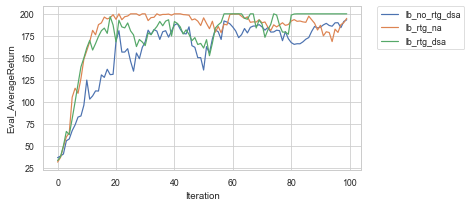

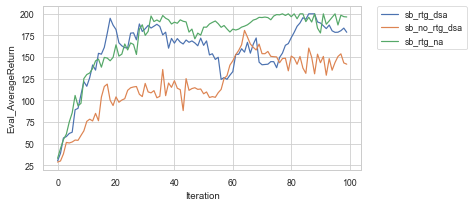

In [458]:
print('large batch')
data_q1_lb = read_data('q1_lb','CartPole-v0')
plot_return(data_q1_lb, 'q1_lb')

print('small batch')
data_q1_sb = read_data('q1_sb','CartPole-v0')
plot_return(data_q1_sb, 'q1_sb')

## add colunms to pandas data

In [543]:
#add colunm


def data_add_column(my_str):
    splits = my_str.split("_")
    for split in splits:
        if split.startswith('b'):
            b = int(split[1:])
        if split.startswith('r0'): 
            lr = float(split[1:])
        
    new_col = (b,lr)

    return pd.Series(new_col)

#data_add_column('b300_r0.002') 



# Experiment 2

q2_b300_r0.02_InvertedPendulum-v2_24-02-2021_12-14-38
q2_b1000_r0.001_InvertedPendulum-v2_24-02-2021_11-40-25
q2_b1000_r0.07_InvertedPendulum-v2_24-02-2021_12-04-54
q2_b10000_r0.001_InvertedPendulum-v2_24-02-2021_11-32-39
q2_b500_r0.08_InvertedPendulum-v2_24-02-2021_12-08-20
q2_b1000_r0.001_InvertedPendulum-v2_24-02-2021_10-41-41
q2_b1000_r0.01_InvertedPendulum-v2_24-02-2021_11-41-15
q2_b800_r0.08_InvertedPendulum-v2_24-02-2021_12-09-46
q2_b10000_r0.1_InvertedPendulum-v2_24-02-2021_11-34-17
q2_b1000_r0.01_InvertedPendulum-v2_24-02-2021_10-42-31
q2_b10000_r0.01_InvertedPendulum-v2_24-02-2021_11-33-27
q2_b100_r0.1_InvertedPendulum-v2_24-02-2021_08-46-41
q2_b500_r0.01_InvertedPendulum-v2_24-02-2021_12-17-55
q2_b1000_r0.08_InvertedPendulum-v2_24-02-2021_11-52-55
q2_b100_r0.001_InvertedPendulum-v2_24-02-2021_08-46-03
q2_b100_r0.01_InvertedPendulum-v2_24-02-2021_08-46-23
q2_b1000_r0.09_InvertedPendulum-v2_24-02-2021_12-03-22
q2_b1000_r0.05_InvertedPendulum-v2_24-02-2021_11-42-06
q2_b300_r0.0

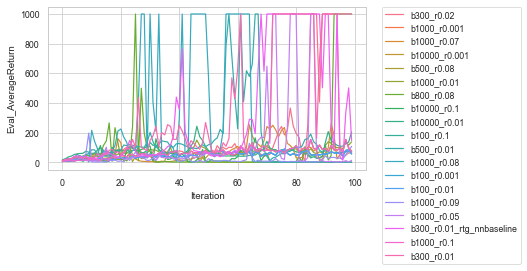

In [500]:


data_q2 = read_data('q2','InvertedPendulum-v2')
data_q2
#plot_return(data_q2, 'q2')


In [547]:
data_q2

,Iteration,Experiment,Train_EnvstepsSoFar,Eval_AverageReturn,batch size,learning rate
0,0,b300_r0.02,301.0,7.214286,300.0,0.02
1,1,b300_r0.02,601.0,18.181818,300.0,0.02
2,2,b300_r0.02,909.0,24.705883,300.0,0.02
3,3,b300_r0.02,1221.0,18.272728,300.0,0.02
4,4,b300_r0.02,1564.0,18.608696,300.0,0.02
...,...,...,...,...,...,...
2095,95,b300_r0.01,50380.0,1000.000000,300.0,0.01
2096,96,b300_r0.01,51380.0,1000.000000,300.0,0.01
2097,97,b300_r0.01,52380.0,1000.000000,300.0,0.01
2098,98,b300_r0.01,53380.0,1000.000000,300.0,0.01


In [567]:
threshold=900
#data_q2[["batch size", "learning rate"]] = data_q2["Experiment"].apply(data_add_column)
data_q2['return_over_threshold']=data_q2['Eval_AverageReturn'] > threshold
list
data_q2['return_over_threshold']





#data_q2.groupby('Experiment')
#data_q2[data_q2['Eval_AverageReturn']>900].groupby('Experiment').count().reset_index()

,Iteration,Experiment,Train_EnvstepsSoFar,Eval_AverageReturn,batch size,learning rate,return_over_threshold,streak_id
0,0,b300_r0.02,301.0,7.214286,300.0,0.02,False,1
1,1,b300_r0.02,601.0,18.181818,300.0,0.02,False,1
2,2,b300_r0.02,909.0,24.705883,300.0,0.02,False,1
3,3,b300_r0.02,1221.0,18.272728,300.0,0.02,False,1
4,4,b300_r0.02,1564.0,18.608696,300.0,0.02,False,1
...,...,...,...,...,...,...,...,...
2095,95,b300_r0.01,50380.0,1000.000000,300.0,0.01,True,46
2096,96,b300_r0.01,51380.0,1000.000000,300.0,0.01,True,46
2097,97,b300_r0.01,52380.0,1000.000000,300.0,0.01,True,46
2098,98,b300_r0.01,53380.0,1000.000000,300.0,0.01,True,46


q2_b300_r0.01_InvertedPendulum-v2_24-02-2021_12-12-52


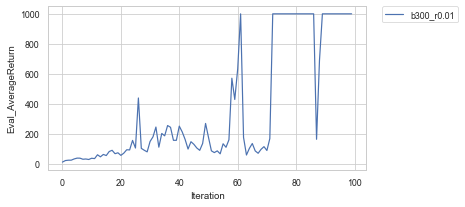

In [574]:
data_q2_optimal = read_data('q2_b300_r0.01','InvertedPendulum-v2')
plot_return(data_q2_optimal, 'q2_optimal')

# Experiment 4

q4_serach_b30000_lr0.02_rtg_nnbaseline_seed_3_HalfCheetah-v2_04-03-2021_20-18-04
q4_serach_b10000_lr0.005_rtg_nnbaseline_seed_3_HalfCheetah-v2_04-03-2021_20-18-03
q4_serach_b10000_lr0.02_rtg_nnbaseline_seed_3_HalfCheetah-v2_04-03-2021_20-18-04
q4_serach_b30000_lr0.005_rtg_nnbaseline_seed_2_HalfCheetah-v2_04-03-2021_20-18-04
q4_serach_b50000_lr0.02_rtg_nnbaseline_seed_1_HalfCheetah-v2_04-03-2021_20-18-05
q4_serach_b30000_lr0.01_rtg_nnbaseline_seed_1_HalfCheetah-v2_04-03-2021_20-18-04
q4_serach_b30000_lr0.005_rtg_nnbaseline_seed_4_HalfCheetah-v2_04-03-2021_20-18-04
q4_serach_b50000_lr0.01_rtg_nnbaseline_seed_3_HalfCheetah-v2_04-03-2021_20-18-04
q4_serach_b10000_lr0.01_rtg_nnbaseline_seed_1_HalfCheetah-v2_04-03-2021_20-18-04
q4_serach_b50000_lr0.005_rtg_nnbaseline_seed_1_HalfCheetah-v2_04-03-2021_20-18-04
q4_serach_b30000_lr0.02_rtg_nnbaseline_seed_2_HalfCheetah-v2_04-03-2021_20-18-04
q4_serach_b10000_lr0.005_rtg_nnbaseline_seed_2_HalfCheetah-v2_04-03-2021_20-18-04
q4_serach_b50000_lr0.02

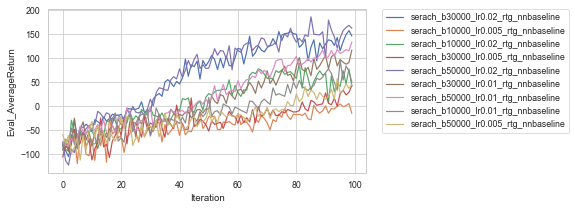

In [557]:
data_q4_serach = read_data('q4_serach','HalfCheetah-v2')
plot_return(data_q4_serach, 'q4_serach')

q4_b50000_lr0.02_seed_2_HalfCheetah-v2_05-03-2021_11-19-34
q4_b50000_lr0.02_nnbaseline_seed_0_HalfCheetah-v2_05-03-2021_13-43-37
q4_b50000_lr0.02_seed_4_HalfCheetah-v2_05-03-2021_11-19-34
q4_b50000_lr0.02_rtg_seed_0_HalfCheetah-v2_05-03-2021_13-43-37
q4_b50000_lr0.02_rtg_nnbaseline_seed_0_HalfCheetah-v2_05-03-2021_11-19-34
q4_b50000_lr0.02_seed_3_HalfCheetah-v2_05-03-2021_11-19-34
q4_b50000_lr0.02_nnbaseline_seed_1_HalfCheetah-v2_05-03-2021_13-43-37
q4_b50000_lr0.02_rtg_seed_1_HalfCheetah-v2_05-03-2021_13-43-37
q4_b50000_lr0.02_rtg_nnbaseline_seed_1_HalfCheetah-v2_05-03-2021_11-19-34
q4_b50000_lr0.02_rtg_nnbaseline_seed_4_HalfCheetah-v2_05-03-2021_11-19-34
q4_b50000_lr0.02_rtg_seed_4_HalfCheetah-v2_05-03-2021_13-43-37
q4_b50000_lr0.02_seed_0_HalfCheetah-v2_05-03-2021_11-19-34
q4_b50000_lr0.02_nnbaseline_seed_2_HalfCheetah-v2_05-03-2021_13-43-37
q4_b50000_lr0.02_nnbaseline_seed_4_HalfCheetah-v2_05-03-2021_13-43-37
q4_b50000_lr0.02_rtg_seed_2_HalfCheetah-v2_05-03-2021_13-43-37
q4_b50000_

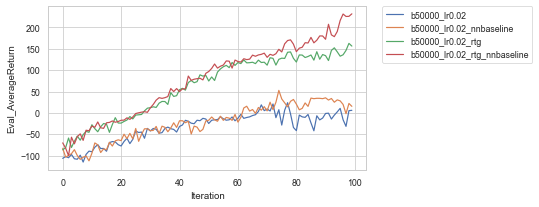

In [558]:
data_q4_optimal = read_data('q4_b','HalfCheetah-v2')
plot_return(data_q4_optimal, 'q4_b')

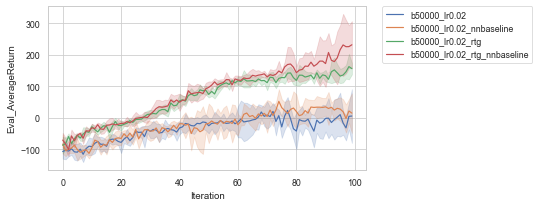

In [560]:
plot_return(data_q4_optimal, 'q4_b',plot_std=True)

# Experiment 3

q3_b40000_r0.005_LunarLanderContinuous-v2_25-02-2021_09-01-56


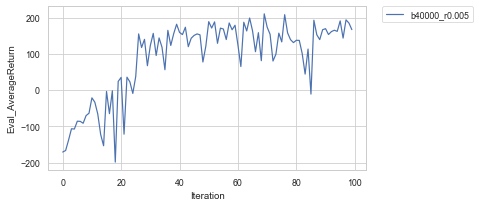

In [559]:
data_q3 = read_data('q3','LunarLanderContinuous-v2')
plot_return(data_q3, 'q3')